In [1]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [4]:
data_dir = Path('../input/')
feature_dir = Path('../feature/')
val_dir = Path('../txt')
tst_dir = Path('../txt')
sub_dir = Path('../submission')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = sub_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [5]:
algo_name = 'lgbcv'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [6]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 26)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,g_r,u_g,r_i,i_z,u_r,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ug,d_dered_gr,d_dered_iz,d_dered_ur,d_dered_ri,d_obs_det
id,,,,,,,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,1.3723,1.1898,0.0,1.3273,2.9272,1.3371,0.7328,4.2545,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,2.8665,1.3027,0.7232,4.1691,1.3230,2.1456
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.5266,1.2533,1.0,0.6096,0.9902,0.1840,0.0995,1.5997,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,0.9619,0.5931,0.1016,1.5550,0.1751,1.3163
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,0.7413,1.0225,0.0,0.2891,0.9610,0.1428,0.0435,1.2501,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,0.9211,0.2466,0.0257,1.1676,0.1183,1.4821
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,0.9591,1.2054,0.0,0.9676,4.4719,0.3262,0.2603,5.4395,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,4.3590,0.9074,0.2395,5.2664,0.2926,1.4454
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,1.2917,1.1939,0.0,1.6568,3.7543,0.7182,0.3415,5.4111,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,3.3376,1.5709,0.3144,4.9084,0.6727,1.9857


In [7]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 25) (80000, 25)


In [8]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [ ]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             n_estimators=1000,
                             num_leaves=64,
                             learning_rate=0.07,
                             min_child_samples=10,
                             subsample=.6,
                             subsample_freq=1,
                             colsample_bytree=.6,
                             random_state=seed,
                             n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=15)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.898251
Training until validation scores don't improve for 15 rounds
[2]	valid_0's multi_logloss: 0.816954
[3]	valid_0's multi_logloss: 0.749697
[4]	valid_0's multi_logloss: 0.690902
[5]	valid_0's multi_logloss: 0.637791
[6]	valid_0's multi_logloss: 0.594062
[7]	valid_0's multi_logloss: 0.555995
[8]	valid_0's multi_logloss: 0.520624
[9]	valid_0's multi_logloss: 0.487135
[10]	valid_0's multi_logloss: 0.459321
[11]	valid_0's multi_logloss: 0.432321
[12]	valid_0's multi_logloss: 0.410019
[13]	valid_0's multi_logloss: 0.390678
[14]	valid_0's multi_logloss: 0.371465
[15]	valid_0's multi_logloss: 0.356394
[16]	valid_0's multi_logloss: 0.342074
[17]	valid_0's multi_logloss: 0.326883
[18]	valid_0's multi_logloss: 0.31231
[19]	valid_0's multi_logloss: 0.300438
[20]	valid_0's multi_logloss: 0.291943
[21]	valid_0's multi_logloss: 0.280838
[22]	valid_0's multi_logloss: 0.270803
[23]	valid_0's multi_logloss: 0.263934
[24]	valid_0's multi_loglos

[208]	valid_0's multi_logloss: 0.155003
[209]	valid_0's multi_logloss: 0.155006
[210]	valid_0's multi_logloss: 0.155006
[211]	valid_0's multi_logloss: 0.154991
[212]	valid_0's multi_logloss: 0.154991
[213]	valid_0's multi_logloss: 0.155023
[214]	valid_0's multi_logloss: 0.155055
[215]	valid_0's multi_logloss: 0.155042
[216]	valid_0's multi_logloss: 0.155054
[217]	valid_0's multi_logloss: 0.155046
[218]	valid_0's multi_logloss: 0.155042
[219]	valid_0's multi_logloss: 0.155037
[220]	valid_0's multi_logloss: 0.155044
[221]	valid_0's multi_logloss: 0.155062
[222]	valid_0's multi_logloss: 0.155042
Early stopping, best iteration is:
[207]	valid_0's multi_logloss: 0.154979
training model for CV #2
[1]	valid_0's multi_logloss: 0.898189
Training until validation scores don't improve for 15 rounds
[2]	valid_0's multi_logloss: 0.817136
[3]	valid_0's multi_logloss: 0.750114
[4]	valid_0's multi_logloss: 0.691707
[5]	valid_0's multi_logloss: 0.638734
[6]	valid_0's multi_logloss: 0.595239
[7]	valid_0

[190]	valid_0's multi_logloss: 0.156421
[191]	valid_0's multi_logloss: 0.156419
[192]	valid_0's multi_logloss: 0.156393
[193]	valid_0's multi_logloss: 0.156365
[194]	valid_0's multi_logloss: 0.156377
[195]	valid_0's multi_logloss: 0.156372
[196]	valid_0's multi_logloss: 0.156359
[197]	valid_0's multi_logloss: 0.156379
[198]	valid_0's multi_logloss: 0.15639
[199]	valid_0's multi_logloss: 0.156426
[200]	valid_0's multi_logloss: 0.156427
[201]	valid_0's multi_logloss: 0.156413
[202]	valid_0's multi_logloss: 0.156441
[203]	valid_0's multi_logloss: 0.156439
[204]	valid_0's multi_logloss: 0.15646
[205]	valid_0's multi_logloss: 0.156439
[206]	valid_0's multi_logloss: 0.156431
[207]	valid_0's multi_logloss: 0.156439
[208]	valid_0's multi_logloss: 0.156423
[209]	valid_0's multi_logloss: 0.156424
[210]	valid_0's multi_logloss: 0.15639
[211]	valid_0's multi_logloss: 0.156366
Early stopping, best iteration is:
[196]	valid_0's multi_logloss: 0.156359
training model for CV #3
[1]	valid_0's multi_log

[185]	valid_0's multi_logloss: 0.1575
[186]	valid_0's multi_logloss: 0.157492
[187]	valid_0's multi_logloss: 0.157486
[188]	valid_0's multi_logloss: 0.157452
[189]	valid_0's multi_logloss: 0.157489
[190]	valid_0's multi_logloss: 0.157487
[191]	valid_0's multi_logloss: 0.157496
[192]	valid_0's multi_logloss: 0.157479
[193]	valid_0's multi_logloss: 0.157467
[194]	valid_0's multi_logloss: 0.157449
[195]	valid_0's multi_logloss: 0.157433
[196]	valid_0's multi_logloss: 0.157424
[197]	valid_0's multi_logloss: 0.157421
[198]	valid_0's multi_logloss: 0.157413
[199]	valid_0's multi_logloss: 0.157387
[200]	valid_0's multi_logloss: 0.157381
[201]	valid_0's multi_logloss: 0.15738
[202]	valid_0's multi_logloss: 0.157381
[203]	valid_0's multi_logloss: 0.157357
[204]	valid_0's multi_logloss: 0.157354
[205]	valid_0's multi_logloss: 0.157365
[206]	valid_0's multi_logloss: 0.157342
[207]	valid_0's multi_logloss: 0.157327
[208]	valid_0's multi_logloss: 0.157302
[209]	valid_0's multi_logloss: 0.157311
[21

[151]	valid_0's multi_logloss: 0.156188
[152]	valid_0's multi_logloss: 0.156171
[153]	valid_0's multi_logloss: 0.156153
[154]	valid_0's multi_logloss: 0.156149
[155]	valid_0's multi_logloss: 0.15613
[156]	valid_0's multi_logloss: 0.156094
[157]	valid_0's multi_logloss: 0.156064
[158]	valid_0's multi_logloss: 0.156047
[159]	valid_0's multi_logloss: 0.156051
[160]	valid_0's multi_logloss: 0.156057
[161]	valid_0's multi_logloss: 0.156041
[162]	valid_0's multi_logloss: 0.156044
[163]	valid_0's multi_logloss: 0.15605
[164]	valid_0's multi_logloss: 0.156052
[165]	valid_0's multi_logloss: 0.156045
[166]	valid_0's multi_logloss: 0.156054
[167]	valid_0's multi_logloss: 0.156046
[168]	valid_0's multi_logloss: 0.155987
[169]	valid_0's multi_logloss: 0.15598
[170]	valid_0's multi_logloss: 0.155958
[171]	valid_0's multi_logloss: 0.15595
[172]	valid_0's multi_logloss: 0.155913
[173]	valid_0's multi_logloss: 0.155913
[174]	valid_0's multi_logloss: 0.1559
[175]	valid_0's multi_logloss: 0.155855
[176]	

[123]	valid_0's multi_logloss: 0.15607
[124]	valid_0's multi_logloss: 0.156034
[125]	valid_0's multi_logloss: 0.15601
[126]	valid_0's multi_logloss: 0.155985
[127]	valid_0's multi_logloss: 0.155925
[128]	valid_0's multi_logloss: 0.155886
[129]	valid_0's multi_logloss: 0.155831
[130]	valid_0's multi_logloss: 0.155779
[131]	valid_0's multi_logloss: 0.155749
[132]	valid_0's multi_logloss: 0.15572
[133]	valid_0's multi_logloss: 0.155703
[134]	valid_0's multi_logloss: 0.155638
[135]	valid_0's multi_logloss: 0.155601
[136]	valid_0's multi_logloss: 0.155564
[137]	valid_0's multi_logloss: 0.155515
[138]	valid_0's multi_logloss: 0.155502
[139]	valid_0's multi_logloss: 0.155458
[140]	valid_0's multi_logloss: 0.155434
[141]	valid_0's multi_logloss: 0.155411
[142]	valid_0's multi_logloss: 0.155389
[143]	valid_0's multi_logloss: 0.155353
[144]	valid_0's multi_logloss: 0.155326
[145]	valid_0's multi_logloss: 0.155304
[146]	valid_0's multi_logloss: 0.155281
[147]	valid_0's multi_logloss: 0.155264
[14

In [21]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.4566%


In [11]:

print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [49]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

<AxesSubplot:ylabel='feature'>

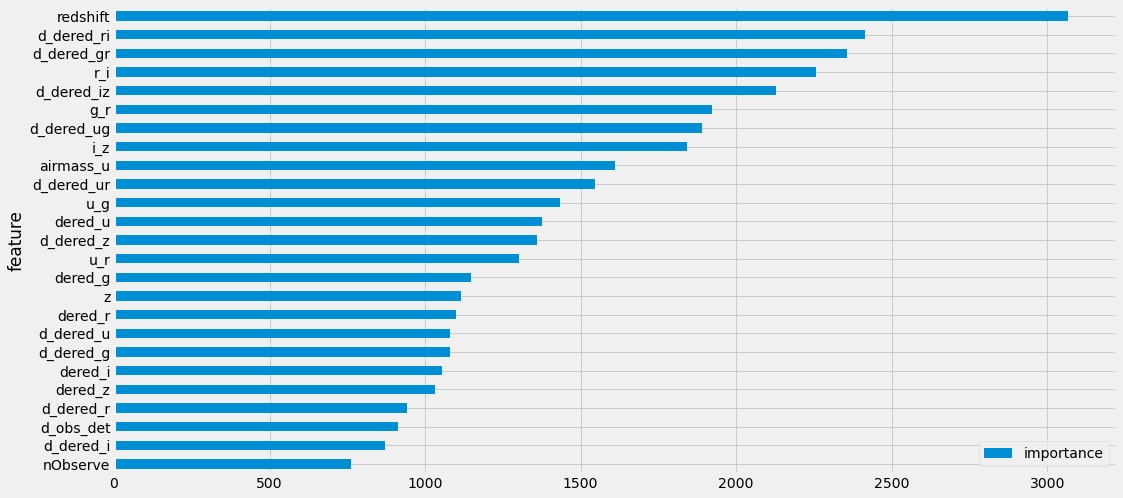

In [22]:

imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [51]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [52]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [16]:
sub[target_col].value_counts()

2    40677
0    29978
1     9345
Name: class, dtype: int64

In [17]:
sub.to_csv(sub_file)